<a href="https://colab.research.google.com/github/VKapicyn/m06-006sk-course-work-var2/blob/master/Ant_Colony_on_1024Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Эксперименты с графом

In [39]:
import networkx as nx
import time

In [3]:
G = nx.gnm_random_graph(1024, 4000, directed=False)

In [4]:
sum = 0
zeros = 0
for i in G:
  sum += G.degree[i]
  if G.degree[i] == 0:
    zeros += 1
print(sum/G.number_of_nodes())
print(zeros)

7.8125
0


In [ ]:
k = 0
for i in range(0,1024):
  if nx.has_path(G,6,i):
    k += 1
print(k)

1024


# Эксперименты с муравьями

Следующий блок кода является модифицированным кодом из репозитория https://github.com/Akavall/AntColonyOptimization

---


Этот блок кода реализует прохождение муравьиной колонии по графу с целью поиска кратчайшего пути (ещё в доработке)

Алгоритм состоит из N итераций. Кол-во итераций задаётся в параметр n_iterations.

---
Содержание каждой итерации:

1. Выпускается K муравьёв (задаётся параметром n_ants) в функции **gen_all_paths()**
2. Собираются путь каждого муравья (ф-я **gen_path()**) при том, что муравей выбирает, куда ему идти в функции **pick_move()**
3. Для каждого собранного пути считается его дистанция (ф-я **gen_path_dist()**)
4. В зависимости от длинны дистанции по неё распыляется феромон (ф-я **spread_pheromone()**)




In [42]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

  def __init__(self, graph, n_ants, n_best, n_iterations, decay, max_moves):

    self.graph = graph
    self.distances  = nx.to_numpy_array(graph)
    self.pheromone = np.copy(self.distances)
    self.n_ants = n_ants
    self.n_best = n_best
    self.n_iterations = n_iterations
    self.decay = decay
    self.alpha = 1
    self.beta = 1
    self.max_moves = max_moves
    self.weights = 0
    self.min_path = max_moves

  #ГОТОВО
  def run(self):
    shortest_path = None
    all_time_shortest_path = ("placeholder", np.inf)
    for i in range(self.n_iterations):
        all_paths = self.gen_all_paths() #получаем все пути муравьёв за эту итерацию
        self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path) #распыляем феромоны на путях в зависимости от их итоговой длинны
        shortest_path = min(all_paths, key=lambda x: x[1]) #находим кратчайший путь из всех муравьиных
        sorted_paths = sorted(all_paths, key=lambda x: x[1]) #сортируем пути по дистанции от минимальной к максимальной, чтобы напечатать
        pr = []
        for p in sorted_paths: 
          pr.append(p[1])
        #print ("short:",shortest_path[1], "weights:", self.weights, "pathes:", pr)
        #если нашли более короткий путь, чем был раньше, то заменяем
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path            
        self.pheromone = self.pheromone * self.decay #испаряем феромон
    self.min_path = shortest_path[1]
    print("shortest:", self.min_path, "weights:", self.weights)
    return all_time_shortest_path

  #ГОТОВО
  def spread_pheronome(self, all_paths, n_best, shortest_path):
    sorted_paths = sorted(all_paths, key=lambda x: x[1]) #сортируем пути по дистанции от минимальной к максимальной
    for path, dist in sorted_paths[:n_best]: #распыляем феромон на пути с наименьшей дистанцией
      if dist < self.max_moves:
        for move in path:
            self.pheromone[move[0]][move[1]] += 25.0 / dist #self.distances[move] #к феромону прибавляется значение обратно пропорциональное пройденной дистанции
  
  #ГОТОВО: суммируем длинну пути
  def gen_path_dist(self, path):
    total_dist = 0
    for step in path:
        total_dist += self.distances[step]
    return total_dist

  #ГОТОВО: собираем пути всех муравьёв
  def gen_all_paths(self):
    all_paths = []
    # выпускаем N муравьёв
    for i in range(self.n_ants):
        path = self.gen_path(start = 0) # каждый муравей проходит свой путь, начиная с 0-го узла
        all_paths.append((path, self.gen_path_dist(path))) # этот путь присоединяется к копилке всех путей этой итерации муравейника
    return all_paths

  # то, как муравей проходит свой путь
  def gen_path(self, start):
    path = []
    #visited = set()
    #visited.add(start)
    weight = 1;
    prev = start
    i = 0
    while (prev != 1023): # цикл до попадания муравья в нужный узел
      move, weight = self.pick_move(self, self.pheromone, prev, path, weight) # муравей выбирает следующий шаг
      path.append((prev,move))
      # муравей, зашедший в тупик, возвращается на базу до следующего выхода
      #if G.degree[move] == 1:
      #  return 0;
      # муравей, гуляющий слишком долго, возвращается на базу до следующего выхода
      i += 1
      if i >= self.max_moves:
        break
      prev = move
    if (prev == 1023): #если всё-таки дошёл, то добавляем вес
      self.weights = self.weights + weight
    return path
  

  def pick_move(self, pheromone, dist, prev, path, old_weight):
      #pheromone = np.copy(pheromone)
      neighbours = np.array(list(self.graph.adj[prev])) # список соседей (вариантов)
      buff = []
      for i in neighbours:
        #if any(p[0] == i for p in path):
        if len(path) != 0 and i == path[-1][0]:
           buff.append(0.000001) # есои муравей там уже был, то вернётся с меньшей вероятностью
        else:
           buff.append(self.pheromone[prev][i])
        
      phers = np.array(buff)# список феромонов на соседях

      #for i in phers:  
      #  i = i ** self.alpha  # предпочтительность соседа при выборе пути. Забил на длинну, так как везде 1
      row = phers ** self.alpha #* (( 1.0 / dist[prev]) ** self.beta) 
      
      #row = np.ones(np.shape(neighbours))
      norm_row = row / row.sum() # нормированная предпочтительность
      
      np.random.seed()
      move = np_choice(a = neighbours, size = 1, p=norm_row)[0] # волшебство выбора
      new_weight = old_weight / (len(neighbours) * norm_row[np.where(neighbours == move)])
      #print(prev, " - ", move)
      return move, new_weight

In [65]:
weight_arr = []
time_arr = []
all_time = 0
for i in range(0,15):
  start = time.time()
  ants = AntColony(G, n_ants = 35, n_best = 5, n_iterations = 20, decay = 0.95, max_moves = 500)
  print ("working... ", i)
  shortest_path = ants.run()
  work_time = time.time() - start
  print ("time:", work_time)
  weight_arr.append(ants.weights)
  time_arr.append(work_time)
  all_time = all_time + work_time

working...  0
shortest: 5.0 weights: [4.61347734]
time: 32.6142156124115
working...  1
shortest: 5.0 weights: [2.4412469]
time: 27.535184383392334
working...  2
shortest: 4.0 weights: [2.15892222]
time: 25.385377407073975
working...  3
shortest: 4.0 weights: [1.90463142]
time: 25.278159856796265
working...  4
shortest: 4.0 weights: [2.97149983]
time: 22.92661714553833
working...  5
shortest: 4.0 weights: [1.66310104]
time: 23.889745473861694
working...  6
shortest: 4.0 weights: [3.22831082]
time: 23.737737894058228
working...  7
shortest: 4.0 weights: [2.06805533]
time: 18.78265953063965
working...  8
shortest: 4.0 weights: [13.88505335]
time: 23.814411163330078
working...  9
shortest: 4.0 weights: [1.57860522]
time: 31.469502210617065
working...  10
shortest: 4.0 weights: [2.35110208]
time: 29.564180374145508
working...  11
shortest: 5.0 weights: [1.11940316]
time: 26.444815635681152
working...  12
shortest: 4.0 weights: [2.39751515]
time: 22.065439701080322
working...  13
shortest: 5

In [46]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show>

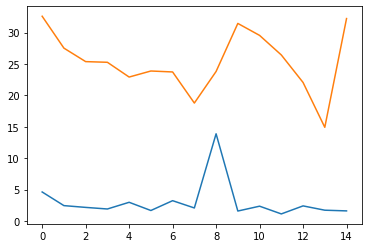

In [66]:
plt.plot(weight_arr)
plt.plot(time_arr)
plt.show

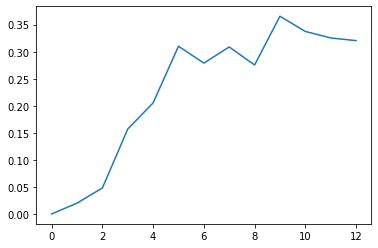

In [78]:
d = []
for i in range(len(weight_arr)):
  if weight_arr[i] > 4:
    weight_arr.pop([i])

for i in range(len(weight_arr)):
    d.append(np.var(weight_arr[:i+1]))

plt.plot(d)
plt.show()

In [73]:
print(weight_arr)

[array([4.61347734]), array([2.4412469]), array([2.15892222]), array([1.90463142]), array([2.97149983]), array([1.66310104]), array([3.22831082]), array([2.06805533]), array([13.88505335]), array([1.57860522]), array([2.35110208]), array([1.11940316]), array([2.39751515]), array([1.71193241]), array([1.60142496])]


In [20]:
print(nx.dijkstra_path(G,0,1023))

[0, 151, 106, 794, 1023]
